In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range
import matplotlib.pyplot as plt

/Users/kuoteng/.pyenv/versions/3.6.4/envs/NCKU-DSAI/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
DATA_SIZE = 60000
TRAIN_SIZE = 45000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+- '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
EPOCH_SIZE = 1
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '+',
 2: '-',
 3: '0',
 4: '1',
 5: '2',
 6: '3',
 7: '4',
 8: '5',
 9: '6',
 10: '7',
 11: '8',
 12: '9'}

# Data Generation

In [7]:
questions = []
expected = []
seen = set()
print('Generating data...')

Generating data...


In [8]:
while len(questions) < DATA_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    if len(questions) % 2 == 0:
        q = '{}-{}'.format(a, b)
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a - b)
    else:
        q = '{}+{}'.format(a, b)
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a + b)
    if q in seen:
        continue
    seen.add(q)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Total addition questions: 60000


In [9]:
print(questions[:5], expected[:5])

['591-536', '8+7    ', '7-55   ', '179+36 ', '46-878 '] ['55  ', '15  ', '-48 ', '215 ', '-832']


# Processing

In [10]:
print('Vectorization... (to the one-hot encoding)')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization... (to the one-hot encoding)


In [11]:
indices = np.arange(len(y))
np.random.shuffle(indices)
print(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:TRAIN_SIZE]
train_y = y[:TRAIN_SIZE]
test_x = x[TRAIN_SIZE:]
test_y = y[TRAIN_SIZE:]

print('Training Data:')
print(train_x.shape)
print(train_y.shape)

split_at = len(train_x) - len(train_x) // 10
print('split_at', split_at)
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)


[39781 32319  8952 ... 22320 11792 20944]
Training Data:
(45000, 7, 13)
(45000, 4, 13)
split_at 40500
Training Data:
(40500, 7, 13)
(40500, 4, 13)
Validation Data:
(4500, 7, 13)
(4500, 4, 13)
Testing Data:
(15000, 7, 13)
(15000, 4, 13)


In [12]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False False False False False False False  True
   False False]
  [False False False False False False False False False False  True
   False False]
  [False  True False False False False False False False False False
   False False]
  [False False False False False False False False False False  True
   False False]
  [ True False False False False False False False False False False
   False False]
  [ True False False False False False False False False False False
   False False]
  [ True False False False False False False False False False False
   False False]]

 [[False False False False False False False  True False False False
   False False]
  [False False False False False False False False False  True False
   False False]
  [False False False False  True False False False False False False
   False False]
  [False  True False False False False False False False False False
   False False]
  [False False False False False  True False False Fals

# Build Model

In [13]:
print('Build model...')
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72704     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 13)             1677      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 13)             0         
Total params: 205,965
Trainable params: 205,965
Non-trainable params: 0
_________________________________________________________________


# Training

In [14]:
acc = []
val_acc = []
loss = []
val_loss = []
guesses = []
for loop in range(100):
    print()
    print('-' * 50)
    print('Train Loop Num:', loop)
    history = model.fit(x_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCH_SIZE,
                  validation_data=(x_val, y_val),
                  shuffle=True)
    acc += history.history['acc']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    val_loss += history.history['val_loss']
    right = 0
    preds = model.predict_classes(test_x, verbose=0)
    for i in range(len(preds)):
        q = ctable.decode(test_x[i])
        correct = ctable.decode(test_y[i])
        guess = ctable.decode(preds[i], calc_argmax=False)
        if correct == guess:
            right += 1
    print("MSG : Accuracy is {}".format(right / len(preds)))
    guesses.append(right / len(preds))


--------------------------------------------------
Train Loop Num: 0
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 228us/step - loss: 1.9182 - acc: 0.3281 - val_loss: 1.7225 - val_acc: 0.3746
MSG : Accuracy is 0.002

--------------------------------------------------
Train Loop Num: 1
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 231us/step - loss: 1.6899 - acc: 0.3811 - val_loss: 1.6571 - val_acc: 0.3982
MSG : Accuracy is 0.0033333333333333335

--------------------------------------------------
Train Loop Num: 2
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 218us/step - loss: 1.6316 - acc: 0.4019 - val_loss: 1.5986 - val_acc: 0.4127
MSG : Accuracy is 0.005933333333333333

--------------------------------------------------
Train Loop Num: 3
Train on 40500 samples, validate on 4500 samples
Epoch 1/1


40500/40500 [==============================] - 9s 218us/step - loss: 0.5040 - acc: 0.8181 - val_loss: 0.5401 - val_acc: 0.7934
MSG : Accuracy is 0.40453333333333336

--------------------------------------------------
Train Loop Num: 29
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 218us/step - loss: 0.4694 - acc: 0.8340 - val_loss: 0.5147 - val_acc: 0.8047
MSG : Accuracy is 0.4412

--------------------------------------------------
Train Loop Num: 30
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 219us/step - loss: 0.4441 - acc: 0.8444 - val_loss: 0.4856 - val_acc: 0.8198
MSG : Accuracy is 0.4716666666666667

--------------------------------------------------
Train Loop Num: 31
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 218us/step - loss: 0.4137 - acc: 0.8572 - val_loss: 0.4624 - val_acc: 0.8279
MS

40500/40500 [==============================] - 9s 215us/step - loss: 0.1213 - acc: 0.9638 - val_loss: 0.2007 - val_acc: 0.9286
MSG : Accuracy is 0.7625333333333333

--------------------------------------------------
Train Loop Num: 57
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 215us/step - loss: 0.0981 - acc: 0.9732 - val_loss: 0.1861 - val_acc: 0.9349
MSG : Accuracy is 0.7843333333333333

--------------------------------------------------
Train Loop Num: 58
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 216us/step - loss: 0.0936 - acc: 0.9749 - val_loss: 0.2234 - val_acc: 0.9214
MSG : Accuracy is 0.7467333333333334

--------------------------------------------------
Train Loop Num: 59
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 218us/step - loss: 0.0955 - acc: 0.9735 - val_loss: 0.1959 - val_acc

40500/40500 [==============================] - 17s 412us/step - loss: 0.0371 - acc: 0.9920 - val_loss: 0.2486 - val_acc: 0.9247
MSG : Accuracy is 0.7484

--------------------------------------------------
Train Loop Num: 85
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 13s 309us/step - loss: 0.1082 - acc: 0.9652 - val_loss: 0.1620 - val_acc: 0.9448
MSG : Accuracy is 0.8153333333333334

--------------------------------------------------
Train Loop Num: 86
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 210us/step - loss: 0.0342 - acc: 0.9938 - val_loss: 0.1403 - val_acc: 0.9542
MSG : Accuracy is 0.8445333333333334

--------------------------------------------------
Train Loop Num: 87
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 211us/step - loss: 0.0253 - acc: 0.9966 - val_loss: 0.1379 - val_acc: 0.9548
M

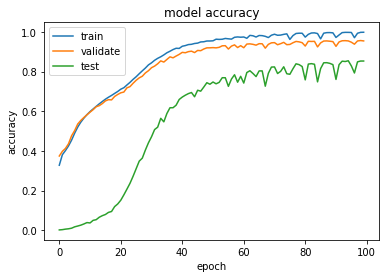

In [15]:
plt.plot(acc)
plt.plot(val_acc)
plt.plot(guesses)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate', 'test'], loc='upper left')
plt.savefig('./fig/addition-subtractor-jupyter-accuracy.png')
plt.show()

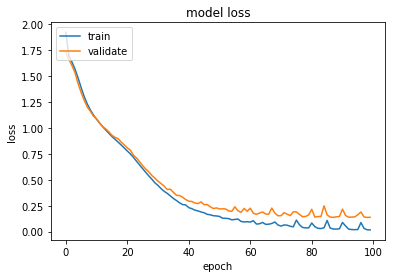

In [16]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.savefig('./fig/addition-subtractor-jupyter-loss.png')
plt.show()

# Testing

In [17]:
print("MSG : Prediction")
print("-" * 50)
right = 0
preds = model.predict_classes(test_x, verbose=0)
for i in range(len(preds)):
    q = ctable.decode(test_x[i])
    correct = ctable.decode(test_y[i])
    guess = ctable.decode(preds[i], calc_argmax=False)
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        print(colors.ok + '☑' + colors.close, end=' ')
        right += 1
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(guess)
print("MSG : Accuracy is {}".format(right / len(preds)))

MSG : Prediction
--------------------------------------------------
Q 95-718  T -623 ☑ -623
Q 694+67  T 761  ☑ 761 
Q 313+68  T 381  ☑ 381 
Q 8-549   T -541 ☑ -541
Q 905-929 T -24  ☒ -13 
Q 157+35  T 192  ☑ 192 
Q 37-225  T -188 ☑ -188
Q 6+534   T 540  ☑ 540 
Q 59+237  T 296  ☑ 296 
Q 71+854  T 925  ☑ 925 
Q 60-870  T -810 ☑ -810
Q 4+325   T 329  ☑ 329 
Q 582+804 T 1386 ☑ 1386
Q 22+92   T 114  ☑ 114 
Q 5-5     T 0    ☑ 0   
Q 359+0   T 359  ☑ 359 
Q 732-0   T 732  ☑ 732 
Q 28+333  T 361  ☑ 361 
Q 367-5   T 362  ☑ 362 
Q 62+763  T 825  ☑ 825 
Q 297-64  T 233  ☑ 233 
Q 64-989  T -925 ☑ -925
Q 949-236 T 713  ☒ 603 
Q 8+385   T 393  ☑ 393 
Q 45-57   T -12  ☑ -12 
Q 484+314 T 798  ☑ 798 
Q 339+516 T 855  ☒ 845 
Q 953+461 T 1414 ☒ 1404
Q 26-76   T -50  ☑ -50 
Q 43+200  T 243  ☑ 243 
Q 22+2    T 24   ☑ 24  
Q 2+656   T 658  ☑ 658 
Q 137+130 T 267  ☑ 267 
Q 77-296  T -219 ☑ -219
Q 135-20  T 115  ☒ 125 
Q 37-837  T -800 ☒ -700
Q 40+126  T 166  ☑ 166 
Q 115+1   T 116  ☑ 116 
Q 482-29  T 453  ☑ 4

Q 79+792  T 871  ☑ 871 
Q 196-786 T -590 ☑ -590
Q 968+18  T 986  ☑ 986 
Q 39+932  T 971  ☑ 971 
Q 44+95   T 139  ☑ 139 
Q 141+4   T 145  ☑ 145 
Q 51+870  T 921  ☑ 921 
Q 566+9   T 575  ☑ 575 
Q 1+774   T 775  ☑ 775 
Q 386+11  T 397  ☑ 397 
Q 861-56  T 805  ☑ 805 
Q 8-349   T -341 ☑ -341
Q 34+2    T 36   ☑ 36  
Q 778+9   T 787  ☑ 787 
Q 681+513 T 1194 ☒ 1294
Q 412-292 T 120  ☑ 120 
Q 1-744   T -743 ☑ -743
Q 186-7   T 179  ☑ 179 
Q 348+9   T 357  ☑ 357 
Q 621-12  T 609  ☑ 609 
Q 97+796  T 893  ☒ 883 
Q 402+6   T 408  ☑ 408 
Q 9+1     T 10   ☑ 10  
Q 31-3    T 28   ☑ 28  
Q 8-3     T 5    ☑ 5   
Q 90+8    T 98   ☑ 98  
Q 402-543 T -141 ☒ -132
Q 66-892  T -826 ☑ -826
Q 958+5   T 963  ☑ 963 
Q 84+912  T 996  ☒ 995 
Q 7-704   T -697 ☑ -697
Q 72-5    T 67   ☑ 67  
Q 893-34  T 859  ☒ 769 
Q 89-1    T 88   ☑ 88  
Q 533+59  T 592  ☑ 592 
Q 13+75   T 88   ☑ 88  
Q 8-214   T -206 ☑ -206
Q 401-2   T 399  ☑ 399 
Q 396+92  T 488  ☑ 488 
Q 88-438  T -350 ☑ -350
Q 518-9   T 509  ☑ 509 
Q 30-573  T -543

Q 81-66   T 15   ☑ 15  
Q 85+0    T 85   ☑ 85  
Q 9+990   T 999  ☑ 999 
Q 5+10    T 15   ☑ 15  
Q 44-244  T -200 ☒ -100
Q 80+86   T 166  ☑ 166 
Q 881-8   T 873  ☑ 873 
Q 392-707 T -315 ☒ -216
Q 724-229 T 495  ☒ 595 
Q 68+202  T 270  ☑ 270 
Q 835-66  T 769  ☑ 769 
Q 39+94   T 133  ☑ 133 
Q 0-642   T -642 ☑ -642
Q 769+83  T 852  ☑ 852 
Q 342-449 T -107 ☒ -93 
Q 769-920 T -151 ☒ -141
Q 941-6   T 935  ☑ 935 
Q 52+457  T 509  ☑ 509 
Q 73+96   T 169  ☑ 169 
Q 129+78  T 207  ☑ 207 
Q 847-68  T 779  ☑ 779 
Q 1-824   T -823 ☑ -823
Q 3-849   T -846 ☑ -846
Q 195+77  T 272  ☒ 273 
Q 82-30   T 52   ☑ 52  
Q 67+97   T 164  ☑ 164 
Q 9-358   T -349 ☑ -349
Q 19-283  T -264 ☑ -264
Q 14+186  T 200  ☑ 200 
Q 0+755   T 755  ☑ 755 
Q 816-489 T 327  ☑ 327 
Q 10+129  T 139  ☑ 139 
Q 22+516  T 538  ☑ 538 
Q 977-1   T 976  ☑ 976 
Q 986-394 T 592  ☒ 583 
Q 97-768  T -671 ☑ -671
Q 691+9   T 700  ☑ 700 
Q 952-23  T 929  ☑ 929 
Q 199-130 T 69   ☒ 179 
Q 6-25    T -19  ☑ -19 
Q 7-799   T -792 ☑ -792
Q 874+29  T 903 

Q 876+0   T 876  ☑ 876 
Q 6+246   T 252  ☑ 252 
Q 49+528  T 577  ☑ 577 
Q 71-869  T -798 ☑ -798
Q 60+719  T 779  ☑ 779 
Q 83+6    T 89   ☑ 89  
Q 233+690 T 923  ☑ 923 
Q 4+319   T 323  ☑ 323 
Q 876-8   T 868  ☑ 868 
Q 853-2   T 851  ☑ 851 
Q 464+75  T 539  ☑ 539 
Q 10+41   T 51   ☑ 51  
Q 197-86  T 111  ☑ 111 
Q 41-201  T -160 ☒ -141
Q 973-41  T 932  ☑ 932 
Q 581+0   T 581  ☑ 581 
Q 6+646   T 652  ☑ 652 
Q 2+288   T 290  ☑ 290 
Q 152-975 T -823 ☑ -823
Q 73+142  T 215  ☑ 215 
Q 6+536   T 542  ☑ 542 
Q 167-362 T -195 ☑ -195
Q 37+488  T 525  ☑ 525 
Q 20+561  T 581  ☑ 581 
Q 279+91  T 370  ☒ 360 
Q 49-477  T -428 ☒ -427
Q 84-139  T -55  ☑ -55 
Q 48+98   T 146  ☑ 146 
Q 829+5   T 834  ☑ 834 
Q 26+661  T 687  ☑ 687 
Q 237+376 T 613  ☑ 613 
Q 703+76  T 779  ☑ 779 
Q 907-60  T 847  ☒ 857 
Q 957-456 T 501  ☑ 501 
Q 53-394  T -341 ☑ -341
Q 102-1   T 101  ☑ 101 
Q 12+13   T 25   ☑ 25  
Q 293+0   T 293  ☑ 293 
Q 5+597   T 602  ☑ 602 
Q 76-533  T -457 ☑ -457
Q 546+33  T 579  ☑ 579 
Q 972+77  T 1049

Q 687+673 T 1360 ☒ 1350
Q 36-975  T -939 ☑ -939
Q 9+589   T 598  ☑ 598 
Q 0-808   T -808 ☑ -808
Q 54+787  T 841  ☑ 841 
Q 30+613  T 643  ☑ 643 
Q 265-9   T 256  ☑ 256 
Q 1-778   T -777 ☑ -777
Q 25+623  T 648  ☑ 648 
Q 129+2   T 131  ☑ 131 
Q 541-4   T 537  ☑ 537 
Q 840-0   T 840  ☑ 840 
Q 544-1   T 543  ☑ 543 
Q 898-1   T 897  ☑ 897 
Q 893+59  T 952  ☑ 952 
Q 257+6   T 263  ☑ 263 
Q 84+760  T 844  ☑ 844 
Q 6+400   T 406  ☑ 406 
Q 847-5   T 842  ☑ 842 
Q 0+517   T 517  ☑ 517 
Q 729+980 T 1709 ☑ 1709
Q 497+7   T 504  ☑ 504 
Q 24+1    T 25   ☑ 25  
Q 175+7   T 182  ☑ 182 
Q 233+490 T 723  ☒ 733 
Q 3-358   T -355 ☑ -355
Q 922-98  T 824  ☑ 824 
Q 57+71   T 128  ☑ 128 
Q 587+25  T 612  ☑ 612 
Q 702-7   T 695  ☑ 695 
Q 268-4   T 264  ☑ 264 
Q 15-54   T -39  ☑ -39 
Q 975+22  T 997  ☑ 997 
Q 50+58   T 108  ☑ 108 
Q 47+923  T 970  ☑ 970 
Q 1+225   T 226  ☑ 226 
Q 883+98  T 981  ☑ 981 
Q 72+984  T 1056 ☑ 1056
Q 2-909   T -907 ☑ -907
Q 648-36  T 612  ☑ 612 
Q 58+69   T 127  ☑ 127 
Q 4-355   T -351

Q 36-95   T -59  ☑ -59 
Q 18+575  T 593  ☑ 593 
Q 54+70   T 124  ☑ 124 
Q 78+705  T 783  ☑ 783 
Q 502-72  T 430  ☒ 431 
Q 12+75   T 87   ☑ 87  
Q 435+4   T 439  ☑ 439 
Q 54-231  T -177 ☑ -177
Q 674+9   T 683  ☑ 683 
Q 637-2   T 635  ☑ 635 
Q 29+840  T 869  ☑ 869 
Q 455+674 T 1129 ☑ 1129
Q 23+8    T 31   ☑ 31  
Q 86-8    T 78   ☑ 78  
Q 385+27  T 412  ☑ 412 
Q 55+78   T 133  ☑ 133 
Q 36+23   T 59   ☑ 59  
Q 59-786  T -727 ☑ -727
Q 950+428 T 1378 ☒ 1388
Q 610+2   T 612  ☑ 612 
Q 825-164 T 661  ☑ 661 
Q 887-345 T 542  ☑ 542 
Q 835+17  T 852  ☑ 852 
Q 6+435   T 441  ☑ 441 
Q 5+546   T 551  ☑ 551 
Q 565+943 T 1508 ☑ 1508
Q 7-5     T 2    ☒ 1   
Q 0-788   T -788 ☑ -788
Q 19-109  T -90  ☒ -91 
Q 91-21   T 70   ☑ 70  
Q 24-50   T -26  ☑ -26 
Q 29+565  T 594  ☒ 504 
Q 62+18   T 80   ☑ 80  
Q 998+63  T 1061 ☑ 1061
Q 230-76  T 154  ☑ 154 
Q 65+854  T 919  ☑ 919 
Q 767+47  T 814  ☑ 814 
Q 372-905 T -533 ☑ -533
Q 751+71  T 822  ☑ 822 
Q 72+712  T 784  ☑ 784 
Q 8-97    T -89  ☑ -89 
Q 114+66  T 180 

Q 865-93  T 772  ☑ 772 
Q 57+146  T 203  ☑ 203 
Q 681-0   T 681  ☑ 681 
Q 73-34   T 39   ☑ 39  
Q 756-36  T 720  ☒ 710 
Q 50-0    T 50   ☑ 50  
Q 368+1   T 369  ☑ 369 
Q 6+709   T 715  ☑ 715 
Q 0-54    T -54  ☑ -54 
Q 24+87   T 111  ☑ 111 
Q 613+15  T 628  ☑ 628 
Q 334+1   T 335  ☑ 335 
Q 28+340  T 368  ☑ 368 
Q 19-26   T -7   ☑ -7  
Q 75+593  T 668  ☑ 668 
Q 690+80  T 770  ☒ 760 
Q 784-471 T 313  ☒ 323 
Q 9+19    T 28   ☑ 28  
Q 7+8     T 15   ☑ 15  
Q 866+6   T 872  ☑ 872 
Q 2+458   T 460  ☑ 460 
Q 474+752 T 1226 ☑ 1226
Q 11-565  T -554 ☑ -554
Q 98+33   T 131  ☑ 131 
Q 27-206  T -179 ☒ -189
Q 142+0   T 142  ☑ 142 
Q 6-820   T -814 ☑ -814
Q 79-929  T -850 ☑ -850
Q 70-6    T 64   ☑ 64  
Q 2+29    T 31   ☑ 31  
Q 20-762  T -742 ☒ -741
Q 8+7     T 15   ☑ 15  
Q 50-51   T -1   ☑ -1  
Q 597-736 T -139 ☑ -139
Q 74-336  T -262 ☑ -262
Q 0+858   T 858  ☑ 858 
Q 17+96   T 113  ☑ 113 
Q 59+62   T 121  ☑ 121 
Q 89+584  T 673  ☑ 673 
Q 4-176   T -172 ☑ -172
Q 84-88   T -4   ☑ -4  
Q 250+5   T 255 

Q 701-758 T -57  ☒ -47 
Q 560-90  T 470  ☑ 470 
Q 223+87  T 310  ☑ 310 
Q 88-86   T 2    ☑ 2   
Q 455-6   T 449  ☑ 449 
Q 891-366 T 525  ☑ 525 
Q 8-509   T -501 ☑ -501
Q 858-851 T 7    ☒ -2  
Q 98-568  T -470 ☑ -470
Q 693-532 T 161  ☒ 151 
Q 862+267 T 1129 ☑ 1129
Q 756-5   T 751  ☑ 751 
Q 434-590 T -156 ☒ -155
Q 28-528  T -500 ☒ -490
Q 171-4   T 167  ☑ 167 
Q 649-77  T 572  ☑ 572 
Q 617-78  T 539  ☒ 549 
Q 2-861   T -859 ☒ -869
Q 262+1   T 263  ☑ 263 
Q 57-397  T -340 ☑ -340
Q 925+947 T 1872 ☑ 1872
Q 8+429   T 437  ☑ 437 
Q 611+598 T 1209 ☑ 1209
Q 53-131  T -78  ☑ -78 
Q 656-525 T 131  ☒ 111 
Q 55-134  T -79  ☒ 189 
Q 14-64   T -50  ☑ -50 
Q 6-208   T -202 ☑ -202
Q 3-500   T -497 ☑ -497
Q 20+64   T 84   ☑ 84  
Q 713+830 T 1543 ☑ 1543
Q 39+819  T 858  ☑ 858 
Q 2-73    T -71  ☑ -71 
Q 87-289  T -202 ☑ -202
Q 158-582 T -424 ☑ -424
Q 8-785   T -777 ☑ -777
Q 518+5   T 523  ☑ 523 
Q 762-411 T 351  ☑ 351 
Q 69-258  T -189 ☑ -189
Q 355+65  T 420  ☑ 420 
Q 264-3   T 261  ☑ 261 
Q 255+34  T 289 

Q 565-95  T 470  ☑ 470 
Q 7-637   T -630 ☑ -630
Q 3+46    T 49   ☑ 49  
Q 676-98  T 578  ☑ 578 
Q 516-97  T 419  ☑ 419 
Q 87-526  T -439 ☑ -439
Q 736+50  T 786  ☑ 786 
Q 685-9   T 676  ☑ 676 
Q 6-800   T -794 ☑ -794
Q 651+0   T 651  ☑ 651 
Q 52+1    T 53   ☑ 53  
Q 844-8   T 836  ☑ 836 
Q 7-468   T -461 ☑ -461
Q 186+98  T 284  ☑ 284 
Q 339+79  T 418  ☑ 418 
Q 48+923  T 971  ☑ 971 
Q 35+86   T 121  ☑ 121 
Q 74+39   T 113  ☑ 113 
Q 516+189 T 705  ☒ 605 
Q 424-64  T 360  ☑ 360 
Q 368+303 T 671  ☒ 661 
Q 58+696  T 754  ☑ 754 
Q 772-915 T -143 ☑ -143
Q 270+462 T 732  ☑ 732 
Q 6+67    T 73   ☑ 73  
Q 71+8    T 79   ☑ 79  
Q 50+890  T 940  ☑ 940 
Q 94-775  T -681 ☑ -681
Q 3+21    T 24   ☑ 24  
Q 371-945 T -574 ☑ -574
Q 365+30  T 395  ☑ 395 
Q 721+1   T 722  ☑ 722 
Q 771-987 T -216 ☑ -216
Q 511+7   T 518  ☑ 518 
Q 82-5    T 77   ☑ 77  
Q 9+67    T 76   ☑ 76  
Q 240+50  T 290  ☑ 290 
Q 4+182   T 186  ☑ 186 
Q 256+25  T 281  ☒ 271 
Q 455-1   T 454  ☑ 454 
Q 758-66  T 692  ☑ 692 
Q 868-851 T 17  

Q 7+502   T 509  ☒ 519 
Q 832-270 T 562  ☒ 552 
Q 813+6   T 819  ☑ 819 
Q 44+68   T 112  ☑ 112 
Q 631-21  T 610  ☒ 600 
Q 4-309   T -305 ☑ -305
Q 649-374 T 275  ☑ 275 
Q 592-0   T 592  ☑ 592 
Q 391+92  T 483  ☑ 483 
Q 74+11   T 85   ☑ 85  
Q 423-33  T 390  ☑ 390 
Q 410-1   T 409  ☑ 409 
Q 38+99   T 137  ☑ 137 
Q 2-164   T -162 ☑ -162
Q 541+271 T 812  ☑ 812 
Q 338+271 T 609  ☑ 609 
Q 6+760   T 766  ☑ 766 
Q 12+242  T 254  ☑ 254 
Q 397+548 T 945  ☒ 1045
Q 91+789  T 880  ☒ 870 
Q 2+279   T 281  ☑ 281 
Q 3+19    T 22   ☑ 22  
Q 9+671   T 680  ☑ 680 
Q 75-172  T -97  ☒ -98 
Q 34-9    T 25   ☑ 25  
Q 40+813  T 853  ☑ 853 
Q 70-672  T -602 ☑ -602
Q 115+951 T 1066 ☒ 1056
Q 39-602  T -563 ☑ -563
Q 847+678 T 1525 ☑ 1525
Q 25+4    T 29   ☑ 29  
Q 243+6   T 249  ☑ 249 
Q 9-774   T -765 ☑ -765
Q 12+82   T 94   ☑ 94  
Q 78-86   T -8   ☑ -8  
Q 781+29  T 810  ☑ 810 
Q 342-8   T 334  ☑ 334 
Q 671-30  T 641  ☑ 641 
Q 2+379   T 381  ☑ 381 
Q 98+289  T 387  ☑ 387 
Q 18-27   T -9   ☑ -9  
Q 95-380  T -285

Q 4+180   T 184  ☑ 184 
Q 46+45   T 91   ☑ 91  
Q 60+398  T 458  ☑ 458 
Q 47-443  T -396 ☑ -396
Q 839+9   T 848  ☑ 848 
Q 579+1   T 580  ☑ 580 
Q 31+19   T 50   ☑ 50  
Q 2+872   T 874  ☑ 874 
Q 8+472   T 480  ☑ 480 
Q 48-650  T -602 ☑ -602
Q 37+358  T 395  ☑ 395 
Q 45-71   T -26  ☑ -26 
Q 912+41  T 953  ☑ 953 
Q 88-2    T 86   ☑ 86  
Q 662+1   T 663  ☑ 663 
Q 626-458 T 168  ☒ 178 
Q 90-747  T -657 ☑ -657
Q 92-752  T -660 ☒ -650
Q 36+985  T 1021 ☑ 1021
Q 165-73  T 92   ☒ 90  
Q 74-354  T -280 ☑ -280
Q 377-731 T -354 ☑ -354
Q 88-7    T 81   ☑ 81  
Q 3-836   T -833 ☑ -833
Q 713+449 T 1162 ☒ 1152
Q 78+24   T 102  ☑ 102 
Q 599+973 T 1572 ☒ 1582
Q 322+62  T 384  ☑ 384 
Q 6-708   T -702 ☑ -702
Q 324-422 T -98  ☒ -188
Q 870+9   T 879  ☑ 879 
Q 9+147   T 156  ☑ 156 
Q 619-33  T 586  ☑ 586 
Q 89-71   T 18   ☑ 18  
Q 84-43   T 41   ☑ 41  
Q 40-624  T -584 ☑ -584
Q 75-21   T 54   ☑ 54  
Q 77-13   T 64   ☑ 64  
Q 800-47  T 753  ☒ 743 
Q 36-75   T -39  ☑ -39 
Q 638+18  T 656  ☑ 656 
Q 1+782   T 783 

Q 339+914 T 1253 ☑ 1253
Q 259-87  T 172  ☑ 172 
Q 521-534 T -13  ☒ -43 
Q 837-84  T 753  ☑ 753 
Q 155-432 T -277 ☒ -177
Q 19+83   T 102  ☑ 102 
Q 122+7   T 129  ☑ 129 
Q 106+5   T 111  ☑ 111 
Q 2-716   T -714 ☑ -714
Q 355-290 T 65   ☒ 655 
Q 22-92   T -70  ☒ -61 
Q 460+126 T 586  ☒ 587 
Q 70+184  T 254  ☑ 254 
Q 55+40   T 95   ☑ 95  
Q 544+4   T 548  ☑ 548 
Q 83+564  T 647  ☑ 647 
Q 273-450 T -177 ☒ -17 
Q 111-112 T -1   ☒ 89  
Q 86+900  T 986  ☑ 986 
Q 719+7   T 726  ☑ 726 
Q 29-2    T 27   ☑ 27  
Q 96-860  T -764 ☑ -764
Q 58-996  T -938 ☑ -938
Q 673-406 T 267  ☑ 267 
Q 826-27  T 799  ☒ 709 
Q 382+41  T 423  ☑ 423 
Q 66-36   T 30   ☑ 30  
Q 443-38  T 405  ☑ 405 
Q 4+696   T 700  ☑ 700 
Q 3-629   T -626 ☑ -626
Q 809-97  T 712  ☑ 712 
Q 837+3   T 840  ☑ 840 
Q 512+29  T 541  ☑ 541 
Q 54-448  T -394 ☑ -394
Q 220+76  T 296  ☑ 296 
Q 374+7   T 381  ☑ 381 
Q 713-2   T 711  ☑ 711 
Q 84-82   T 2    ☒ 1   
Q 60+16   T 76   ☑ 76  
Q 431-984 T -553 ☑ -553
Q 96-5    T 91   ☑ 91  
Q 98-58   T 40  

Q 7-502   T -495 ☑ -495
Q 7+542   T 549  ☑ 549 
Q 18+15   T 33   ☑ 33  
Q 91+819  T 910  ☒ 900 
Q 806+161 T 967  ☒ 977 
Q 389-1   T 388  ☑ 388 
Q 612+5   T 617  ☑ 617 
Q 242+973 T 1215 ☑ 1215
Q 5+783   T 788  ☑ 788 
Q 481-4   T 477  ☑ 477 
Q 9-372   T -363 ☑ -363
Q 6+539   T 545  ☑ 545 
Q 11-750  T -739 ☒ -730
Q 909-937 T -28  ☒ -38 
Q 88+424  T 512  ☑ 512 
Q 1-267   T -266 ☑ -266
Q 4-706   T -702 ☑ -702
Q 43-35   T 8    ☑ 8   
Q 525+3   T 528  ☑ 528 
Q 26+949  T 975  ☑ 975 
Q 45-807  T -762 ☑ -762
Q 86+78   T 164  ☑ 164 
Q 974+2   T 976  ☑ 976 
Q 94-547  T -453 ☑ -453
Q 69-0    T 69   ☑ 69  
Q 41+113  T 154  ☑ 154 
Q 392+69  T 461  ☑ 461 
Q 8-475   T -467 ☑ -467
Q 832-6   T 826  ☑ 826 
Q 231-709 T -478 ☑ -478
Q 830-6   T 824  ☑ 824 
Q 38-173  T -135 ☑ -135
Q 7+545   T 552  ☑ 552 
Q 28-29   T -1   ☒ -   
Q 320+9   T 329  ☑ 329 
Q 8+236   T 244  ☑ 244 
Q 816-7   T 809  ☑ 809 
Q 618+686 T 1304 ☒ 1204
Q 30-757  T -727 ☑ -727
Q 58-825  T -767 ☑ -767
Q 14-8    T 6    ☑ 6   
Q 828-14  T 814 

Q 30-392  T -362 ☑ -362
Q 73+176  T 249  ☑ 249 
Q 68-45   T 23   ☑ 23  
Q 650-236 T 414  ☒ 415 
Q 562+96  T 658  ☑ 658 
Q 18+394  T 412  ☑ 412 
Q 11-916  T -905 ☑ -905
Q 67-11   T 56   ☑ 56  
Q 2+797   T 799  ☑ 799 
Q 978+87  T 1065 ☑ 1065
Q 139+8   T 147  ☑ 147 
Q 671+9   T 680  ☒ 670 
Q 8-253   T -245 ☑ -245
Q 563+0   T 563  ☑ 563 
Q 70+789  T 859  ☑ 859 
Q 979-81  T 898  ☒ 998 
Q 3+962   T 965  ☑ 965 
Q 9-777   T -768 ☑ -768
Q 72-58   T 14   ☑ 14  
Q 3+932   T 935  ☑ 935 
Q 74+315  T 389  ☑ 389 
Q 4+713   T 717  ☑ 717 
Q 677+9   T 686  ☑ 686 
Q 862+582 T 1444 ☑ 1444
Q 3+794   T 797  ☑ 797 
Q 771-936 T -165 ☒ -156
Q 0-841   T -841 ☑ -841
Q 15-43   T -28  ☑ -28 
Q 9+718   T 727  ☑ 727 
Q 43+30   T 73   ☑ 73  
Q 734+86  T 820  ☑ 820 
Q 45-18   T 27   ☑ 27  
Q 211-420 T -209 ☒ -219
Q 87-368  T -281 ☑ -281
Q 462+68  T 530  ☒ 539 
Q 668+61  T 729  ☑ 729 
Q 997-77  T 920  ☒ 910 
Q 40+47   T 87   ☑ 87  
Q 5-979   T -974 ☑ -974
Q 6+525   T 531  ☑ 531 
Q 238-9   T 229  ☒ 239 
Q 755+9   T 764 

Q 75+95   T 170  ☑ 170 
Q 846-79  T 767  ☒ 757 
Q 136+6   T 142  ☑ 142 
Q 892+20  T 912  ☑ 912 
Q 49-305  T -256 ☑ -256
Q 70+383  T 453  ☑ 453 
Q 9+729   T 738  ☑ 738 
Q 28-18   T 10   ☑ 10  
Q 103+7   T 110  ☑ 110 
Q 72+50   T 122  ☑ 122 
Q 8+42    T 50   ☒ 40  
Q 8-129   T -121 ☑ -121
Q 162-83  T 79   ☑ 79  
Q 624-8   T 616  ☑ 616 
Q 208+28  T 236  ☑ 236 
Q 123+946 T 1069 ☒ 1079
Q 0-846   T -846 ☑ -846
Q 85+9    T 94   ☑ 94  
Q 457-610 T -153 ☒ -143
Q 509+50  T 559  ☑ 559 
Q 354+1   T 355  ☑ 355 
Q 79+78   T 157  ☑ 157 
Q 20+83   T 103  ☑ 103 
Q 1-66    T -65  ☑ -65 
Q 364+1   T 365  ☑ 365 
Q 919+96  T 1015 ☑ 1015
Q 930+752 T 1682 ☒ 1672
Q 719+23  T 742  ☑ 742 
Q 0-713   T -713 ☑ -713
Q 300+99  T 399  ☒ 409 
Q 42+741  T 783  ☑ 783 
Q 44+104  T 148  ☑ 148 
Q 840+926 T 1766 ☑ 1766
Q 19-77   T -58  ☑ -58 
Q 325+4   T 329  ☑ 329 
Q 49+752  T 801  ☑ 801 
Q 453-816 T -363 ☑ -363
Q 58+50   T 108  ☑ 108 
Q 6+637   T 643  ☑ 643 
Q 225-1   T 224  ☑ 224 
Q 520+332 T 852  ☑ 852 
Q 57-16   T 41  

Q 673+61  T 734  ☑ 734 
Q 3+300   T 303  ☑ 303 
Q 75-315  T -240 ☑ -240
Q 55+15   T 70   ☑ 70  
Q 9+921   T 930  ☑ 930 
Q 50-124  T -74  ☑ -74 
Q 173+4   T 177  ☑ 177 
Q 642-4   T 638  ☑ 638 
Q 7+735   T 742  ☑ 742 
Q 295-6   T 289  ☑ 289 
Q 532-98  T 434  ☑ 434 
Q 8+542   T 550  ☑ 550 
Q 50-626  T -576 ☒ -575
Q 12+8    T 20   ☑ 20  
Q 932+2   T 934  ☑ 934 
Q 593-49  T 544  ☑ 544 
Q 79+39   T 118  ☑ 118 
Q 34+99   T 133  ☑ 133 
Q 4+637   T 641  ☑ 641 
Q 70-817  T -747 ☑ -747
Q 140-37  T 103  ☑ 103 
Q 212-3   T 209  ☑ 209 
Q 77-709  T -632 ☑ -632
Q 77-69   T 8    ☒ 9   
Q 343-50  T 293  ☒ 393 
Q 280+8   T 288  ☑ 288 
Q 76+40   T 116  ☑ 116 
Q 0+994   T 994  ☑ 994 
Q 72-201  T -129 ☑ -129
Q 912+0   T 912  ☑ 912 
Q 795+8   T 803  ☑ 803 
Q 406+63  T 469  ☒ 479 
Q 938+24  T 962  ☑ 962 
Q 824-4   T 820  ☑ 820 
Q 1+50    T 51   ☑ 51  
Q 791+9   T 800  ☑ 800 
Q 85-55   T 30   ☑ 30  
Q 29+14   T 43   ☑ 43  
Q 241+60  T 301  ☒ 201 
Q 985-4   T 981  ☑ 981 
Q 449-65  T 384  ☑ 384 
Q 568-7   T 561 

Q 542-5   T 537  ☑ 537 
Q 4-268   T -264 ☑ -264
Q 858-29  T 829  ☑ 829 
Q 520-5   T 515  ☑ 515 
Q 49+873  T 922  ☑ 922 
Q 6-996   T -990 ☑ -990
Q 5+351   T 356  ☑ 356 
Q 130+21  T 151  ☒ 161 
Q 633+7   T 640  ☑ 640 
Q 834-66  T 768  ☑ 768 
Q 10+82   T 92   ☑ 92  
Q 23-26   T -3   ☑ -3  
Q 26+678  T 704  ☑ 704 
Q 536+76  T 612  ☑ 612 
Q 13+449  T 462  ☑ 462 
Q 492+24  T 516  ☑ 516 
Q 935-1   T 934  ☑ 934 
Q 71+4    T 75   ☑ 75  
Q 357-2   T 355  ☑ 355 
Q 0+401   T 401  ☑ 401 
Q 7+12    T 19   ☒ 29  
Q 872+36  T 908  ☑ 908 
Q 383-0   T 383  ☑ 383 
Q 906+1   T 907  ☑ 907 
Q 499-993 T -494 ☑ -494
Q 324-49  T 275  ☑ 275 
Q 39+591  T 630  ☒ 620 
Q 259-94  T 165  ☑ 165 
Q 91-279  T -188 ☑ -188
Q 66-807  T -741 ☑ -741
Q 40+27   T 67   ☑ 67  
Q 0-10    T -10  ☑ -10 
Q 1-298   T -297 ☑ -297
Q 7-138   T -131 ☑ -131
Q 50+882  T 932  ☑ 932 
Q 3+263   T 266  ☑ 266 
Q 11-941  T -930 ☒ -920
Q 32-59   T -27  ☑ -27 
Q 6+917   T 923  ☑ 923 
Q 50-24   T 26   ☑ 26  
Q 94-791  T -697 ☑ -697
Q 745+57  T 802 

Q 56-626  T -570 ☑ -570
Q 251-948 T -697 ☑ -697
Q 26+3    T 29   ☑ 29  
Q 294-36  T 258  ☑ 258 
Q 18+854  T 872  ☑ 872 
Q 461-189 T 272  ☑ 272 
Q 24+976  T 1000 ☑ 1000
Q 91-415  T -324 ☒ -334
Q 62+512  T 574  ☑ 574 
Q 6-648   T -642 ☑ -642
Q 832+683 T 1515 ☒ 1505
Q 2-626   T -624 ☑ -624
Q 50-682  T -632 ☒ -631
Q 358+846 T 1204 ☒ 1214
Q 27+20   T 47   ☑ 47  
Q 659-6   T 653  ☑ 653 
Q 99-88   T 11   ☑ 11  
Q 46+8    T 54   ☑ 54  
Q 245+6   T 251  ☑ 251 
Q 5+297   T 302  ☑ 302 
Q 92+23   T 115  ☑ 115 
Q 973+31  T 1004 ☑ 1004
Q 180-3   T 177  ☑ 177 
Q 536-2   T 534  ☑ 534 
Q 743-56  T 687  ☑ 687 
Q 955-2   T 953  ☑ 953 
Q 56+1    T 57   ☑ 57  
Q 8+424   T 432  ☑ 432 
Q 27-330  T -303 ☑ -303
Q 471-79  T 392  ☑ 392 
Q 998-674 T 324  ☒ 315 
Q 57+143  T 200  ☒ 100 
Q 76-408  T -332 ☑ -332
Q 394+6   T 400  ☑ 400 
Q 670+93  T 763  ☑ 763 
Q 404+8   T 412  ☑ 412 
Q 2+818   T 820  ☒ 810 
Q 591-1   T 590  ☑ 590 
Q 231-48  T 183  ☑ 183 
Q 213+5   T 218  ☑ 218 
Q 873+694 T 1567 ☑ 1567
Q 489-403 T 86  

Q 8-224   T -216 ☑ -216
Q 6-475   T -469 ☑ -469
Q 759+41  T 800  ☑ 800 
Q 25-12   T 13   ☑ 13  
Q 46-66   T -20  ☑ -20 
Q 65-108  T -43  ☑ -43 
Q 547-356 T 191  ☑ 191 
Q 28-4    T 24   ☑ 24  
Q 95-95   T 0    ☑ 0   
Q 13+22   T 35   ☑ 35  
Q 234+91  T 325  ☑ 325 
Q 707-822 T -115 ☒ -145
Q 960+319 T 1279 ☒ 1289
Q 67-406  T -339 ☑ -339
Q 507+9   T 516  ☑ 516 
Q 882+753 T 1635 ☑ 1635
Q 798-338 T 460  ☒ 551 
Q 201-823 T -622 ☒ -611
Q 7-707   T -700 ☑ -700
Q 48-821  T -773 ☑ -773
Q 430+1   T 431  ☑ 431 
Q 182+550 T 732  ☑ 732 
Q 367+325 T 692  ☒ 792 
Q 73-90   T -17  ☑ -17 
Q 569-787 T -218 ☒ -208
Q 586-54  T 532  ☑ 532 
Q 300+8   T 308  ☑ 308 
Q 8+306   T 314  ☑ 314 
Q 985-712 T 273  ☒ 233 
Q 51-162  T -111 ☒ -110
Q 3-110   T -107 ☑ -107
Q 13-141  T -128 ☑ -128
Q 630+807 T 1437 ☑ 1437
Q 424+714 T 1138 ☑ 1138
Q 9+944   T 953  ☑ 953 
Q 97-117  T -20  ☑ -20 
Q 23+65   T 88   ☑ 88  
Q 64+4    T 68   ☑ 68  
Q 357-783 T -426 ☑ -426
Q 25+449  T 474  ☑ 474 
Q 177+5   T 182  ☑ 182 
Q 158-980 T -822

Q 611-8   T 603  ☑ 603 
Q 657+3   T 660  ☑ 660 
Q 896-148 T 748  ☒ 759 
Q 183-24  T 159  ☑ 159 
Q 274+600 T 874  ☒ 884 
Q 27+697  T 724  ☑ 724 
Q 87-622  T -535 ☑ -535
Q 469-898 T -429 ☒ -439
Q 728-97  T 631  ☒ 632 
Q 8+433   T 441  ☑ 441 
Q 60-67   T -7   ☒ -8  
Q 48+287  T 335  ☑ 335 
Q 23+78   T 101  ☑ 101 
Q 476-3   T 473  ☑ 473 
Q 842-105 T 737  ☑ 737 
Q 209+5   T 214  ☑ 214 
Q 665+25  T 690  ☑ 690 
Q 4+648   T 652  ☑ 652 
Q 0+169   T 169  ☒ 179 
Q 928-852 T 76   ☒ 65  
Q 914+17  T 931  ☑ 931 
Q 164+9   T 173  ☑ 173 
Q 4+405   T 409  ☑ 409 
Q 394+29  T 423  ☒ 433 
Q 446-743 T -297 ☑ -297
Q 85+87   T 172  ☑ 172 
Q 5-125   T -120 ☑ -120
Q 856-86  T 770  ☑ 770 
Q 112+23  T 135  ☑ 135 
Q 9-423   T -414 ☑ -414
Q 7-579   T -572 ☑ -572
Q 58-414  T -356 ☑ -356
Q 123-623 T -500 ☒ -490
Q 591+5   T 596  ☑ 596 
Q 678-927 T -249 ☑ -249
Q 9+939   T 948  ☑ 948 
Q 4+43    T 47   ☑ 47  
Q 18+911  T 929  ☑ 929 
Q 112+227 T 339  ☒ 340 
Q 39-17   T 22   ☑ 22  
Q 473+24  T 497  ☑ 497 
Q 987-675 T 312 

Q 617+511 T 1128 ☒ 1238
Q 900-6   T 894  ☑ 894 
Q 645-3   T 642  ☑ 642 
Q 752+595 T 1347 ☑ 1347
Q 69+699  T 768  ☑ 768 
Q 2-984   T -982 ☑ -982
Q 3+772   T 775  ☑ 775 
Q 7-560   T -553 ☑ -553
Q 1-96    T -95  ☑ -95 
Q 5-104   T -99  ☑ -99 
Q 554+976 T 1530 ☒ 1520
Q 428+380 T 808  ☑ 808 
Q 423+8   T 431  ☑ 431 
Q 147+98  T 245  ☑ 245 
Q 343-47  T 296  ☑ 296 
Q 18+864  T 882  ☑ 882 
Q 63+627  T 690  ☑ 690 
Q 4-143   T -139 ☑ -139
Q 32-39   T -7   ☑ -7  
Q 170-68  T 102  ☒ 112 
Q 6+655   T 661  ☑ 661 
Q 901+3   T 904  ☑ 904 
Q 120-8   T 112  ☑ 112 
Q 235-1   T 234  ☑ 234 
Q 829+875 T 1704 ☑ 1704
Q 990+8   T 998  ☑ 998 
Q 4+4     T 8    ☑ 8   
Q 228-7   T 221  ☑ 221 
Q 505-850 T -345 ☑ -345
Q 473-716 T -243 ☑ -243
Q 5-0     T 5    ☒ 4   
Q 6+13    T 19   ☒ 29  
Q 26-5    T 21   ☑ 21  
Q 4-745   T -741 ☒ -751
Q 14+327  T 341  ☒ 340 
Q 648-183 T 465  ☒ 475 
Q 161-1   T 160  ☑ 160 
Q 130+162 T 292  ☒ 382 
Q 99-81   T 18   ☑ 18  
Q 505+328 T 833  ☑ 833 
Q 44-5    T 39   ☑ 39  
Q 3-119   T -116

Q 85-41   T 44   ☑ 44  
Q 597+740 T 1337 ☒ 1437
Q 170+649 T 819  ☑ 819 
Q 37+81   T 118  ☑ 118 
Q 756+771 T 1527 ☑ 1527
Q 177+566 T 743  ☑ 743 
Q 89-490  T -401 ☑ -401
Q 667-677 T -10  ☑ -10 
Q 18+804  T 822  ☑ 822 
Q 23-757  T -734 ☑ -734
Q 594-59  T 535  ☑ 535 
Q 4-16    T -12  ☑ -12 
Q 64+966  T 1030 ☑ 1030
Q 96-74   T 22   ☑ 22  
Q 402-53  T 349  ☑ 349 
Q 977+72  T 1049 ☑ 1049
Q 112+608 T 720  ☑ 720 
Q 95+480  T 575  ☑ 575 
Q 769-728 T 41   ☒ 44  
Q 465+89  T 554  ☑ 554 
Q 4-536   T -532 ☑ -532
Q 59-35   T 24   ☑ 24  
Q 721+179 T 900  ☒ 800 
Q 445-548 T -103 ☑ -103
Q 466-330 T 136  ☒ 145 
Q 365-1   T 364  ☑ 364 
Q 73-97   T -24  ☑ -24 
Q 482+6   T 488  ☑ 488 
Q 671-13  T 658  ☑ 658 
Q 10+35   T 45   ☑ 45  
Q 45+719  T 764  ☑ 764 
Q 92+525  T 617  ☑ 617 
Q 401-88  T 313  ☑ 313 
Q 134+767 T 901  ☒ 801 
Q 6-742   T -736 ☑ -736
Q 7+563   T 570  ☑ 570 
Q 81-50   T 31   ☑ 31  
Q 88+816  T 904  ☑ 904 
Q 965-215 T 750  ☒ 740 
Q 324+63  T 387  ☑ 387 
Q 825-84  T 741  ☒ 740 
Q 686-18  T 668 

Q 18+159  T 177  ☑ 177 
Q 15+616  T 631  ☑ 631 
Q 0-326   T -326 ☑ -326
Q 361-155 T 206  ☒ 207 
Q 9-312   T -303 ☑ -303
Q 43-434  T -391 ☑ -391
Q 712+48  T 760  ☑ 760 
Q 552+6   T 558  ☑ 558 
Q 71-0    T 71   ☑ 71  
Q 411-5   T 406  ☑ 406 
Q 646+470 T 1116 ☑ 1116
Q 2+53    T 55   ☑ 55  
Q 152+3   T 155  ☑ 155 
Q 2-969   T -967 ☑ -967
Q 9-388   T -379 ☑ -379
Q 50-480  T -430 ☑ -430
Q 78+74   T 152  ☑ 152 
Q 3-768   T -765 ☑ -765
Q 34+266  T 300  ☑ 300 
Q 531+4   T 535  ☑ 535 
Q 22+890  T 912  ☑ 912 
Q 3+29    T 32   ☑ 32  
Q 482+65  T 547  ☑ 547 
Q 3-823   T -820 ☑ -820
Q 315+3   T 318  ☑ 318 
Q 3-236   T -233 ☑ -233
Q 787-14  T 773  ☑ 773 
Q 234-2   T 232  ☑ 232 
Q 44+461  T 505  ☑ 505 
Q 980-815 T 165  ☒ 175 
Q 354-85  T 269  ☑ 269 
Q 588+881 T 1469 ☑ 1469
Q 965+119 T 1084 ☒ 1064
Q 9-64    T -55  ☑ -55 
Q 0+67    T 67   ☑ 67  
Q 605+569 T 1174 ☒ 1155
Q 1-574   T -573 ☑ -573
Q 43-329  T -286 ☑ -286
Q 3+233   T 236  ☑ 236 
Q 656-745 T -89  ☒ -100
Q 2+632   T 634  ☑ 634 
Q 807-73  T 734 

Q 44-361  T -317 ☑ -317
Q 357+140 T 497  ☒ 597 
Q 44-54   T -10  ☑ -10 
Q 954+231 T 1185 ☒ 1186
Q 559-44  T 515  ☑ 515 
Q 44+429  T 473  ☑ 473 
Q 938-918 T 20   ☒ 10  
Q 97-315  T -218 ☒ -228
Q 7+809   T 816  ☑ 816 
Q 339-2   T 337  ☑ 337 
Q 8-10    T -2   ☒ -1  
Q 96+42   T 138  ☑ 138 
Q 66+94   T 160  ☑ 160 
Q 363-6   T 357  ☑ 357 
Q 79+3    T 82   ☑ 82  
Q 384-7   T 377  ☑ 377 
Q 854-113 T 741  ☒ 731 
Q 632+234 T 866  ☑ 866 
Q 32+31   T 63   ☑ 63  
Q 11-93   T -82  ☑ -82 
Q 168+22  T 190  ☑ 190 
Q 9+134   T 143  ☑ 143 
Q 98-669  T -571 ☑ -571
Q 14-30   T -16  ☑ -16 
Q 403+973 T 1376 ☒ 1387
Q 42-38   T 4    ☑ 4   
Q 51+795  T 846  ☑ 846 
Q 556-13  T 543  ☑ 543 
Q 85+970  T 1055 ☑ 1055
Q 19-695  T -676 ☑ -676
Q 69-848  T -779 ☑ -779
Q 53+332  T 385  ☑ 385 
Q 3-34    T -31  ☑ -31 
Q 32+899  T 931  ☒ 930 
Q 69+770  T 839  ☑ 839 
Q 703+664 T 1367 ☒ 1377
Q 2+245   T 247  ☑ 247 
Q 71-933  T -862 ☑ -862
Q 2-15    T -13  ☑ -13 
Q 599-47  T 552  ☑ 552 
Q 10+86   T 96   ☑ 96  
Q 0+404   T 404 

Q 1-682   T -681 ☑ -681
Q 232-74  T 158  ☑ 158 
Q 29+8    T 37   ☑ 37  
Q 724-3   T 721  ☑ 721 
Q 800-663 T 137  ☑ 137 
Q 1-620   T -619 ☑ -619
Q 84+259  T 343  ☑ 343 
Q 2-427   T -425 ☑ -425
Q 20+115  T 135  ☒ 136 
Q 102+547 T 649  ☒ 659 
Q 49-31   T 18   ☑ 18  
Q 597-53  T 544  ☑ 544 
Q 2+402   T 404  ☑ 404 
Q 1-290   T -289 ☑ -289
Q 6-753   T -747 ☑ -747
Q 27+17   T 44   ☑ 44  
Q 107+47  T 154  ☑ 154 
Q 89+504  T 593  ☒ 503 
Q 455+709 T 1164 ☑ 1164
Q 8-360   T -352 ☑ -352
Q 47+545  T 592  ☑ 592 
Q 94-32   T 62   ☑ 62  
Q 52-563  T -511 ☑ -511
Q 334-246 T 88   ☒ 98  
Q 889+0   T 889  ☒ 899 
Q 319+40  T 359  ☑ 359 
Q 695-16  T 679  ☑ 679 
Q 633-722 T -89  ☒ -88 
Q 224-65  T 159  ☑ 159 
Q 18+628  T 646  ☑ 646 
Q 45+332  T 377  ☑ 377 
Q 311-67  T 244  ☑ 244 
Q 396+781 T 1177 ☑ 1177
Q 934+5   T 939  ☑ 939 
Q 27-5    T 22   ☑ 22  
Q 17+272  T 289  ☑ 289 
Q 27-908  T -881 ☑ -881
Q 558-204 T 354  ☑ 354 
Q 251-5   T 246  ☑ 246 
Q 8+37    T 45   ☑ 45  
Q 5+565   T 570  ☑ 570 
Q 147+86  T 233 

Q 2-97    T -95  ☑ -95 
Q 95+1    T 96   ☑ 96  
Q 307+88  T 395  ☑ 395 
Q 541+270 T 811  ☑ 811 
Q 557+8   T 565  ☑ 565 
Q 722+0   T 722  ☑ 722 
Q 51+466  T 517  ☑ 517 
Q 470+980 T 1450 ☑ 1450
Q 167-24  T 143  ☑ 143 
Q 42-239  T -197 ☑ -197
Q 445+0   T 445  ☑ 445 
Q 731-0   T 731  ☑ 731 
Q 86+307  T 393  ☑ 393 
Q 757+35  T 792  ☑ 792 
Q 151+0   T 151  ☑ 151 
Q 760+9   T 769  ☑ 769 
Q 3-459   T -456 ☑ -456
Q 94+87   T 181  ☑ 181 
Q 0+915   T 915  ☑ 915 
Q 52+656  T 708  ☑ 708 
Q 423+69  T 492  ☑ 492 
Q 96-63   T 33   ☑ 33  
Q 60+211  T 271  ☑ 271 
Q 615-2   T 613  ☑ 613 
Q 7+893   T 900  ☑ 900 
Q 60+273  T 333  ☑ 333 
Q 36+531  T 567  ☑ 567 
Q 113-8   T 105  ☑ 105 
Q 46+903  T 949  ☑ 949 
Q 53+7    T 60   ☑ 60  
Q 40+49   T 89   ☑ 89  
Q 99+82   T 181  ☑ 181 
Q 544+25  T 569  ☑ 569 
Q 1+598   T 599  ☒ 699 
Q 74+292  T 366  ☑ 366 
Q 459+5   T 464  ☑ 464 
Q 613-872 T -259 ☒ -269
Q 139+6   T 145  ☑ 145 
Q 57-95   T -38  ☑ -38 
Q 797+6   T 803  ☑ 803 
Q 6+967   T 973  ☑ 973 
Q 755-285 T 470 

Q 799+804 T 1603 ☑ 1603
Q 425+1   T 426  ☑ 426 
Q 428+85  T 513  ☑ 513 
Q 486+57  T 543  ☑ 543 
Q 852-680 T 172  ☒ 152 
Q 945-574 T 371  ☒ 370 
Q 274-318 T -44  ☑ -44 
Q 683-66  T 617  ☑ 617 
Q 0-909   T -909 ☑ -909
Q 92+444  T 536  ☑ 536 
Q 92-72   T 20   ☒ 11  
Q 3-518   T -515 ☑ -515
Q 3-400   T -397 ☑ -397
Q 640+829 T 1469 ☑ 1469
Q 37+465  T 502  ☑ 502 
Q 246+68  T 314  ☑ 314 
Q 287+60  T 347  ☒ 357 
Q 4-654   T -650 ☑ -650
Q 614-283 T 331  ☒ 321 
Q 970-292 T 678  ☒ 689 
Q 13+745  T 758  ☑ 758 
Q 419+175 T 594  ☒ 684 
Q 892-7   T 885  ☑ 885 
Q 525-326 T 199  ☒ 109 
Q 66+707  T 773  ☑ 773 
Q 554-841 T -287 ☑ -287
Q 78-98   T -20  ☑ -20 
Q 35+571  T 606  ☑ 606 
Q 957-50  T 907  ☑ 907 
Q 387-27  T 360  ☑ 360 
Q 44+14   T 58   ☑ 58  
Q 2+672   T 674  ☑ 674 
Q 25-62   T -37  ☑ -37 
Q 4-897   T -893 ☑ -893
Q 452+241 T 693  ☒ 793 
Q 739-455 T 284  ☒ 294 
Q 397+81  T 478  ☑ 478 
Q 45-2    T 43   ☑ 43  
Q 727+90  T 817  ☑ 817 
Q 205-5   T 200  ☑ 200 
Q 8+233   T 241  ☑ 241 
Q 494-46  T 448 

Q 386-66  T 320  ☑ 320 
Q 585-919 T -334 ☒ -324
Q 218-3   T 215  ☑ 215 
Q 54+242  T 296  ☑ 296 
Q 769+58  T 827  ☑ 827 
Q 468+996 T 1464 ☑ 1464
Q 6-44    T -38  ☑ -38 
Q 85-25   T 60   ☑ 60  
Q 37+57   T 94   ☑ 94  
Q 93+90   T 183  ☑ 183 
Q 59-532  T -473 ☑ -473
Q 365+69  T 434  ☑ 434 
Q 521-636 T -115 ☒ -105
Q 573+60  T 633  ☑ 633 
Q 153+77  T 230  ☑ 230 
Q 8-487   T -479 ☑ -479
Q 20+266  T 286  ☑ 286 
Q 413+5   T 418  ☑ 418 
Q 731+938 T 1669 ☑ 1669
Q 67-208  T -141 ☑ -141
Q 65-280  T -215 ☑ -215
Q 41+652  T 693  ☑ 693 
Q 988-14  T 974  ☑ 974 
Q 56+747  T 803  ☑ 803 
Q 90+959  T 1049 ☑ 1049
Q 46-781  T -735 ☑ -735
Q 199-79  T 120  ☒ 110 
Q 803-585 T 218  ☒ 208 
Q 73+191  T 264  ☑ 264 
Q 55+350  T 405  ☑ 405 
Q 7-565   T -558 ☑ -558
Q 127+71  T 198  ☑ 198 
Q 24-19   T 5    ☑ 5   
Q 31+578  T 609  ☑ 609 
Q 75-697  T -622 ☑ -622
Q 756-364 T 392  ☒ 303 
Q 79+700  T 779  ☑ 779 
Q 89+6    T 95   ☑ 95  
Q 2-551   T -549 ☑ -549
Q 10+2    T 12   ☑ 12  
Q 428+7   T 435  ☑ 435 
Q 77-71   T 6   

Q 334+6   T 340  ☑ 340 
Q 3-912   T -909 ☑ -909
Q 7-564   T -557 ☑ -557
Q 4-363   T -359 ☑ -359
Q 610-33  T 577  ☑ 577 
Q 7-743   T -736 ☑ -736
Q 313-26  T 287  ☑ 287 
Q 5+730   T 735  ☑ 735 
Q 724-85  T 639  ☒ 649 
Q 596+75  T 671  ☑ 671 
Q 496-55  T 441  ☑ 441 
Q 301-0   T 301  ☑ 301 
Q 619-650 T -31  ☒ -32 
Q 438+309 T 747  ☑ 747 
Q 428+91  T 519  ☒ 529 
Q 660+4   T 664  ☑ 664 
Q 5+713   T 718  ☑ 718 
Q 16-232  T -216 ☑ -216
Q 544-9   T 535  ☑ 535 
Q 640+707 T 1347 ☑ 1347
Q 83+87   T 170  ☑ 170 
Q 686+5   T 691  ☑ 691 
Q 25+329  T 354  ☑ 354 
Q 8-492   T -484 ☑ -484
Q 678-8   T 670  ☑ 670 
Q 660-968 T -308 ☒ -307
Q 22+421  T 443  ☑ 443 
Q 58-504  T -446 ☑ -446
Q 5+199   T 204  ☑ 204 
Q 737+61  T 798  ☒ 898 
Q 98-47   T 51   ☑ 51  
Q 36+514  T 550  ☑ 550 
Q 133+85  T 218  ☑ 218 
Q 10-223  T -213 ☑ -213
Q 781+7   T 788  ☑ 788 
Q 115+6   T 121  ☑ 121 
Q 4-692   T -688 ☑ -688
Q 642-227 T 415  ☑ 415 
Q 8+723   T 731  ☑ 731 
Q 163-9   T 154  ☑ 154 
Q 871+27  T 898  ☑ 898 
Q 228-43  T 185 

Q 670-7   T 663  ☑ 663 
Q 91-28   T 63   ☑ 63  
Q 229-752 T -523 ☑ -523
Q 766+67  T 833  ☑ 833 
Q 841-952 T -111 ☒ -110
Q 6+549   T 555  ☑ 555 
Q 13+514  T 527  ☑ 527 
Q 897+53  T 950  ☑ 950 
Q 65+984  T 1049 ☑ 1049
Q 467+953 T 1420 ☒ 1429
Q 1+22    T 23   ☑ 23  
Q 225+833 T 1058 ☑ 1058
Q 544+36  T 580  ☒ 570 
Q 244+185 T 429  ☑ 429 
Q 19-879  T -860 ☑ -860
Q 647-79  T 568  ☑ 568 
Q 4+603   T 607  ☑ 607 
Q 179+2   T 181  ☒ 191 
Q 0+419   T 419  ☑ 419 
Q 27-17   T 10   ☑ 10  
Q 780-6   T 774  ☑ 774 
Q 19-732  T -713 ☑ -713
Q 24-91   T -67  ☑ -67 
Q 27+481  T 508  ☑ 508 
Q 257-11  T 246  ☑ 246 
Q 5-27    T -22  ☑ -22 
Q 4+450   T 454  ☑ 454 
Q 907-897 T 10   ☑ 10  
Q 998+78  T 1076 ☑ 1076
Q 5-329   T -324 ☑ -324
Q 92+997  T 1089 ☒ 1080
Q 213-6   T 207  ☑ 207 
Q 347-84  T 263  ☑ 263 
Q 15+34   T 49   ☑ 49  
Q 55-58   T -3   ☑ -3  
Q 919-4   T 915  ☑ 915 
Q 43+98   T 141  ☑ 141 
Q 85-34   T 51   ☑ 51  
Q 61-630  T -569 ☑ -569
Q 10+23   T 33   ☑ 33  
Q 308+20  T 328  ☑ 328 
Q 82+9    T 91  

Q 4-524   T -520 ☑ -520
Q 824-3   T 821  ☑ 821 
Q 900-825 T 75   ☒ 76  
Q 82+77   T 159  ☑ 159 
Q 311-5   T 306  ☑ 306 
Q 9-80    T -71  ☒ -72 
Q 275-146 T 129  ☑ 129 
Q 969-87  T 882  ☑ 882 
Q 80-12   T 68   ☑ 68  
Q 28-443  T -415 ☑ -415
Q 58+56   T 114  ☑ 114 
Q 878-6   T 872  ☑ 872 
Q 619+22  T 641  ☑ 641 
Q 346-4   T 342  ☑ 342 
Q 477-14  T 463  ☑ 463 
Q 146-69  T 77   ☑ 77  
Q 90+660  T 750  ☑ 750 
Q 977-634 T 343  ☑ 343 
Q 9+433   T 442  ☑ 442 
Q 23+86   T 109  ☑ 109 
Q 7-714   T -707 ☑ -707
Q 56-494  T -438 ☑ -438
Q 13-934  T -921 ☑ -921
Q 13-603  T -590 ☑ -590
Q 99+50   T 149  ☑ 149 
Q 476+595 T 1071 ☒ 1061
Q 473-363 T 110  ☒ 100 
Q 49+35   T 84   ☑ 84  
Q 1-483   T -482 ☑ -482
Q 346-87  T 259  ☑ 259 
Q 67+467  T 534  ☑ 534 
Q 413+0   T 413  ☑ 413 
Q 37-44   T -7   ☑ -7  
Q 776-4   T 772  ☑ 772 
Q 314+87  T 401  ☑ 401 
Q 5+367   T 372  ☑ 372 
Q 101-781 T -680 ☒ -670
Q 855-4   T 851  ☑ 851 
Q 5+295   T 300  ☑ 300 
Q 94-29   T 65   ☑ 65  
Q 724+2   T 726  ☑ 726 
Q 7-605   T -598

Q 90+5    T 95   ☑ 95  
Q 4-800   T -796 ☑ -796
Q 139+79  T 218  ☑ 218 
Q 41+78   T 119  ☑ 119 
Q 11+128  T 139  ☑ 139 
Q 41-763  T -722 ☑ -722
Q 48-707  T -659 ☑ -659
Q 2+636   T 638  ☑ 638 
Q 33-62   T -29  ☑ -29 
Q 3-16    T -13  ☑ -13 
Q 9+612   T 621  ☑ 621 
Q 64+54   T 118  ☑ 118 
Q 9-61    T -52  ☑ -52 
Q 51+10   T 61   ☑ 61  
Q 922-954 T -32  ☒ -23 
Q 8+975   T 983  ☑ 983 
Q 0+372   T 372  ☑ 372 
Q 659+5   T 664  ☑ 664 
Q 94+328  T 422  ☑ 422 
Q 3-172   T -169 ☑ -169
Q 70+261  T 331  ☑ 331 
Q 169+1   T 170  ☑ 170 
Q 76+0    T 76   ☑ 76  
Q 701-0   T 701  ☑ 701 
Q 69-67   T 2    ☒ 1   
Q 686-69  T 617  ☑ 617 
Q 932+4   T 936  ☑ 936 
Q 617+17  T 634  ☑ 634 
Q 0+811   T 811  ☑ 811 
Q 5-778   T -773 ☑ -773
Q 449-7   T 442  ☑ 442 
Q 3-299   T -296 ☑ -296
Q 836+17  T 853  ☑ 853 
Q 625+813 T 1438 ☑ 1438
Q 756-91  T 665  ☑ 665 
Q 776-709 T 67   ☒ 93  
Q 43+579  T 622  ☑ 622 
Q 923-8   T 915  ☑ 915 
Q 15+527  T 542  ☑ 542 
Q 51+59   T 110  ☑ 110 
Q 1+94    T 95   ☑ 95  
Q 663-201 T 462 

Q 409+19  T 428  ☑ 428 
Q 473-466 T 7    ☒ 78  
Q 94+2    T 96   ☑ 96  
Q 25+206  T 231  ☑ 231 
Q 5+917   T 922  ☑ 922 
Q 59-4    T 55   ☑ 55  
Q 5+742   T 747  ☑ 747 
Q 3+720   T 723  ☑ 723 
Q 412+1   T 413  ☑ 413 
Q 380-1   T 379  ☑ 379 
Q 95-26   T 69   ☒ 79  
Q 657+95  T 752  ☑ 752 
Q 712+435 T 1147 ☑ 1147
Q 249-790 T -541 ☑ -541
Q 13-4    T 9    ☒ 90  
Q 505-245 T 260  ☒ 259 
Q 806+538 T 1344 ☑ 1344
Q 978+64  T 1042 ☑ 1042
Q 74-9    T 65   ☑ 65  
Q 29-1    T 28   ☑ 28  
Q 810+46  T 856  ☑ 856 
Q 6-407   T -401 ☑ -401
Q 316-7   T 309  ☑ 309 
Q 19-67   T -48  ☑ -48 
Q 97-134  T -37  ☑ -37 
Q 719+8   T 727  ☑ 727 
Q 22-36   T -14  ☑ -14 
Q 6-309   T -303 ☑ -303
Q 558+414 T 972  ☒ 973 
Q 592+13  T 605  ☑ 605 
Q 36-285  T -249 ☑ -249
Q 70+595  T 665  ☑ 665 
Q 0-691   T -691 ☑ -691
Q 45+269  T 314  ☑ 314 
Q 69+89   T 158  ☑ 158 
Q 482+5   T 487  ☑ 487 
Q 182-604 T -422 ☒ -423
Q 583+1   T 584  ☑ 584 
Q 951-44  T 907  ☑ 907 
Q 73-79   T -6   ☑ -6  
Q 50+481  T 531  ☑ 531 
Q 243+5   T 248 

Q 342+253 T 595  ☒ 585 
Q 71+94   T 165  ☑ 165 
Q 77+854  T 931  ☑ 931 
Q 268+6   T 274  ☑ 274 
Q 907-3   T 904  ☑ 904 
Q 9+353   T 362  ☑ 362 
Q 316-0   T 316  ☑ 316 
Q 54-86   T -32  ☑ -32 
Q 473-4   T 469  ☑ 469 
Q 38-683  T -645 ☑ -645
Q 721-1   T 720  ☒ 710 
Q 62-625  T -563 ☑ -563
Q 2-166   T -164 ☑ -164
Q 1+965   T 966  ☑ 966 
Q 47+51   T 98   ☑ 98  
Q 11+614  T 625  ☑ 625 
Q 89-989  T -900 ☑ -900
Q 334-302 T 32   ☒ 53  
Q 303-3   T 300  ☒ 200 
Q 3-20    T -17  ☑ -17 
Q 841-8   T 833  ☑ 833 
Q 24-79   T -55  ☑ -55 
Q 99-957  T -858 ☒ -868
Q 333+316 T 649  ☒ 659 
Q 468-27  T 441  ☑ 441 
Q 6+44    T 50   ☑ 50  
Q 65-3    T 62   ☑ 62  
Q 81+25   T 106  ☑ 106 
Q 972-525 T 447  ☑ 447 
Q 49+62   T 111  ☑ 111 
Q 6+149   T 155  ☑ 155 
Q 356-994 T -638 ☒ -648
Q 570-19  T 551  ☑ 551 
Q 226+723 T 949  ☑ 949 
Q 356-894 T -538 ☑ -538
Q 448+4   T 452  ☑ 452 
Q 628-2   T 626  ☑ 626 
Q 156+9   T 165  ☑ 165 
Q 30+99   T 129  ☑ 129 
Q 5+154   T 159  ☑ 159 
Q 365+322 T 687  ☒ 697 
Q 0+512   T 512 

Q 50+858  T 908  ☑ 908 
Q 323+581 T 904  ☑ 904 
Q 763-668 T 95   ☒ 92  
Q 21-67   T -46  ☑ -46 
Q 339-3   T 336  ☑ 336 
Q 951-3   T 948  ☑ 948 
Q 631-505 T 126  ☑ 126 
Q 34-927  T -893 ☑ -893
Q 630-46  T 584  ☑ 584 
Q 52-25   T 27   ☑ 27  
Q 9+930   T 939  ☑ 939 
Q 325-933 T -608 ☒ -618
Q 39-31   T 8    ☑ 8   
Q 71+802  T 873  ☑ 873 
Q 22+138  T 160  ☑ 160 
Q 90+949  T 1039 ☑ 1039
Q 5+152   T 157  ☑ 157 
Q 328-1   T 327  ☑ 327 
Q 86-970  T -884 ☑ -884
Q 40-348  T -308 ☒ -208
Q 82+84   T 166  ☑ 166 
Q 336+641 T 977  ☑ 977 
Q 12-809  T -797 ☒ -897
Q 10-67   T -57  ☑ -57 
Q 51-4    T 47   ☑ 47  
Q 906+3   T 909  ☑ 909 
Q 238+3   T 241  ☑ 241 
Q 26-914  T -888 ☑ -888
Q 903-208 T 695  ☑ 695 
Q 512-6   T 506  ☑ 506 
Q 1+159   T 160  ☑ 160 
Q 463+1   T 464  ☑ 464 
Q 980+811 T 1791 ☒ 1781
Q 34+389  T 423  ☑ 423 
Q 49-237  T -188 ☑ -188
Q 637-9   T 628  ☑ 628 
Q 517-171 T 346  ☑ 346 
Q 181+0   T 181  ☑ 181 
Q 8-712   T -704 ☑ -704
Q 8+93    T 101  ☑ 101 
Q 377-5   T 372  ☑ 372 
Q 67+71   T 138 

Q 21+4    T 25   ☑ 25  
Q 106-8   T 98   ☒ 99  
Q 923+0   T 923  ☑ 923 
Q 845-0   T 845  ☑ 845 
Q 963+792 T 1755 ☑ 1755
Q 446-361 T 85   ☒ 77  
Q 46+52   T 98   ☑ 98  
Q 8-726   T -718 ☑ -718
Q 58+95   T 153  ☑ 153 
Q 789-1   T 788  ☑ 788 
Q 65-65   T 0    ☑ 0   
Q 348-98  T 250  ☒ 240 
Q 7-75    T -68  ☑ -68 
Q 0-40    T -40  ☑ -40 
Q 364-24  T 340  ☑ 340 
Q 46+926  T 972  ☑ 972 
Q 858-36  T 822  ☑ 822 
Q 6-199   T -193 ☑ -193
Q 302+824 T 1126 ☑ 1126
Q 545-727 T -182 ☑ -182
Q 45+142  T 187  ☑ 187 
Q 185+714 T 899  ☒ 909 
Q 16-771  T -755 ☑ -755
Q 472-777 T -305 ☒ -295
Q 715-43  T 672  ☑ 672 
Q 313+96  T 409  ☑ 409 
Q 70+799  T 869  ☑ 869 
Q 418+7   T 425  ☑ 425 
Q 71+29   T 100  ☑ 100 
Q 7+466   T 473  ☑ 473 
Q 37-20   T 17   ☑ 17  
Q 14-106  T -92  ☑ -92 
Q 156-40  T 116  ☑ 116 
Q 543+0   T 543  ☑ 543 
Q 459-54  T 405  ☑ 405 
Q 97-352  T -255 ☑ -255
Q 41-27   T 14   ☑ 14  
Q 27+443  T 470  ☑ 470 
Q 89-83   T 6    ☒ 5   
Q 181+514 T 695  ☒ 795 
Q 2+387   T 389  ☑ 389 
Q 5-686   T -681

Q 538-473 T 65   ☒ 15  
Q 290+7   T 297  ☑ 297 
Q 84+624  T 708  ☑ 708 
Q 709-15  T 694  ☑ 694 
Q 32+811  T 843  ☑ 843 
Q 6-676   T -670 ☑ -670
Q 672+9   T 681  ☑ 681 
Q 621-474 T 147  ☒ 157 
Q 11+65   T 76   ☑ 76  
Q 884-3   T 881  ☑ 881 
Q 888+612 T 1500 ☒ 1490
Q 18+20   T 38   ☑ 38  
Q 78-124  T -46  ☑ -46 
Q 5+63    T 68   ☑ 68  
Q 198-2   T 196  ☑ 196 
Q 499-95  T 404  ☑ 404 
Q 90+0    T 90   ☑ 90  
Q 138-28  T 110  ☒ 109 
Q 44+627  T 671  ☑ 671 
Q 661-36  T 625  ☑ 625 
Q 0-91    T -91  ☑ -91 
Q 568+417 T 985  ☑ 985 
Q 375+41  T 416  ☑ 416 
Q 541+5   T 546  ☑ 546 
Q 3+956   T 959  ☑ 959 
Q 9-843   T -834 ☑ -834
Q 7-230   T -223 ☑ -223
Q 37-35   T 2    ☒ 1   
Q 6-13    T -7   ☑ -7  
Q 0-948   T -948 ☑ -948
Q 400+57  T 457  ☑ 457 
Q 9-483   T -474 ☑ -474
Q 67-691  T -624 ☑ -624
Q 77-600  T -523 ☑ -523
Q 657-538 T 119  ☑ 119 
Q 80+262  T 342  ☑ 342 
Q 221-415 T -194 ☒ -204
Q 514+710 T 1224 ☒ 1225
Q 442+5   T 447  ☑ 447 
Q 462+42  T 504  ☑ 504 
Q 2+669   T 671  ☑ 671 
Q 64+85   T 149 

Q 869+1   T 870  ☑ 870 
Q 33-421  T -388 ☑ -388
Q 7-536   T -529 ☑ -529
Q 552-99  T 453  ☑ 453 
Q 70-510  T -440 ☑ -440
Q 34-241  T -207 ☑ -207
Q 191+78  T 269  ☑ 269 
Q 0+254   T 254  ☑ 254 
Q 564+3   T 567  ☑ 567 
Q 12-989  T -977 ☑ -977
Q 706+0   T 706  ☑ 706 
Q 74+1    T 75   ☑ 75  
Q 11+671  T 682  ☑ 682 
Q 517-97  T 420  ☑ 420 
Q 727-25  T 702  ☑ 702 
Q 754-45  T 709  ☑ 709 
Q 3-682   T -679 ☑ -679
Q 167+49  T 216  ☑ 216 
Q 719-683 T 36   ☒ 45  
Q 0+507   T 507  ☑ 507 
Q 134-100 T 34   ☒ 145 
Q 76+409  T 485  ☑ 485 
Q 434+29  T 463  ☑ 463 
Q 912-21  T 891  ☑ 891 
Q 363-82  T 281  ☑ 281 
Q 64-37   T 27   ☑ 27  
Q 543+84  T 627  ☑ 627 
Q 719+27  T 746  ☑ 746 
Q 1+482   T 483  ☑ 483 
Q 655+51  T 706  ☒ 705 
Q 744-30  T 714  ☑ 714 
Q 7-21    T -14  ☑ -14 
Q 323+2   T 325  ☑ 325 
Q 9+190   T 199  ☑ 199 
Q 474+614 T 1088 ☒ 1098
Q 367+55  T 422  ☑ 422 
Q 289-578 T -289 ☒ -299
Q 68+406  T 474  ☑ 474 
Q 62+663  T 725  ☑ 725 
Q 530-51  T 479  ☒ 489 
Q 400-566 T -166 ☒ -155
Q 645-14  T 631 

Q 283-174 T 109  ☑ 109 
Q 81-474  T -393 ☑ -393
Q 293+88  T 381  ☑ 381 
Q 68-69   T -1   ☑ -1  
Q 25-29   T -4   ☑ -4  
Q 3-703   T -700 ☑ -700
Q 3+996   T 999  ☑ 999 
Q 60+51   T 111  ☑ 111 
Q 898-650 T 248  ☑ 248 
Q 55+34   T 89   ☑ 89  
Q 220-824 T -604 ☑ -604
Q 26-7    T 19   ☑ 19  
Q 617-26  T 591  ☑ 591 
Q 149-6   T 143  ☑ 143 
Q 25+16   T 41   ☑ 41  
Q 961+233 T 1194 ☒ 1204
Q 292-40  T 252  ☑ 252 
Q 218+933 T 1151 ☒ 1152
Q 88+536  T 624  ☑ 624 
Q 230-3   T 227  ☑ 227 
Q 0-545   T -545 ☑ -545
Q 5-744   T -739 ☑ -739
Q 6-254   T -248 ☑ -248
Q 96-37   T 59   ☑ 59  
Q 77+56   T 133  ☑ 133 
Q 78-64   T 14   ☑ 14  
Q 40-113  T -73  ☑ -73 
Q 35+30   T 65   ☑ 65  
Q 7+166   T 173  ☑ 173 
Q 560+906 T 1466 ☒ 1366
Q 89-584  T -495 ☑ -495
Q 74-786  T -712 ☑ -712
Q 21+67   T 88   ☑ 88  
Q 74-64   T 10   ☒ 1   
Q 347+1   T 348  ☑ 348 
Q 9+578   T 587  ☑ 587 
Q 6+434   T 440  ☑ 440 
Q 66-52   T 14   ☑ 14  
Q 405-56  T 349  ☑ 349 
Q 934+2   T 936  ☑ 936 
Q 225-244 T -19  ☒ -20 
Q 5-535   T -530

Q 47+879  T 926  ☑ 926 
Q 767+1   T 768  ☑ 768 
Q 615+6   T 621  ☑ 621 
Q 8-748   T -740 ☑ -740
Q 517+7   T 524  ☑ 524 
Q 60-939  T -879 ☑ -879
Q 6-493   T -487 ☑ -487
Q 10+7    T 17   ☑ 17  
Q 7-135   T -128 ☑ -128
Q 620+6   T 626  ☑ 626 
Q 5+697   T 702  ☑ 702 
Q 82+79   T 161  ☑ 161 
Q 92-98   T -6   ☑ -6  
Q 3-605   T -602 ☑ -602
Q 37-81   T -44  ☑ -44 
Q 61+82   T 143  ☑ 143 
Q 907+7   T 914  ☑ 914 
Q 360-617 T -257 ☒ -254
Q 69+483  T 552  ☑ 552 
Q 2+18    T 20   ☑ 20  
Q 921+243 T 1164 ☑ 1164
Q 8+371   T 379  ☒ 389 
Q 7-32    T -25  ☑ -25 
Q 109-7   T 102  ☑ 102 
Q 0+390   T 390  ☑ 390 
Q 424+58  T 482  ☑ 482 
Q 58+301  T 359  ☑ 359 
Q 409-7   T 402  ☑ 402 
Q 607+2   T 609  ☑ 609 
Q 917-59  T 858  ☑ 858 
Q 98+821  T 919  ☑ 919 
Q 370+4   T 374  ☑ 374 
Q 582-618 T -36  ☒ -24 
Q 455+61  T 516  ☑ 516 
Q 552+716 T 1268 ☑ 1268
Q 485-6   T 479  ☑ 479 
Q 568-74  T 494  ☑ 494 
Q 70-9    T 61   ☑ 61  
Q 386+82  T 468  ☑ 468 
Q 474-113 T 361  ☑ 361 
Q 385+462 T 847  ☑ 847 
Q 858-285 T 573 

In [18]:
# print("MSG : Prediction")
# test_x = ["555+275", "860+7  ", "340+29 "]
# test_y = ["830 ", "867 ", "369 "]
# x = np.zeros((len(test_x), MAXLEN, len(chars)), dtype=np.bool)
# y = np.zeros((len(test_y), DIGITS + 1, len(chars)), dtype=np.bool)
# for j, (i, c) in enumerate(zip(test_x, test_y)):
#     x[j] = ctable.encode(i, MAXLEN)
#     y[j] = ctable.encode(c, DIGITS + 1)